## For each bee id, be able to provide the number of detections in the hive in the given timeslot.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import math
import seaborn as sns
import numpy as np
import pandas as pd
import psycopg2
import psycopg2.extras
from datetime import timedelta, datetime
from bee_helpers import detections_to_presence, calc_trip_lengths
import time

import bb_utils
import bb_utils.meta
import bb_utils.ids
import bb_backend
from bb_backend.api import FramePlotter, VideoPlotter
from bb_backend.api import get_plot_coordinates, transform_axis_coordinates, get_image_origin

bb_backend.api.server_adress = 'localhost:8000'
connect_str = """dbname='beesbook' user='reader' host='tonic.imp.fu-berlin.de' 
                 password='' application_name='mehmed'"""

meta = bb_utils.meta.BeeMetaInfo()


from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Define constant parameters 

In [2]:
#Parameters for loading data, currently using known date of 23th, august 2016)
num_hours = 24
datetime_start = datetime(2016, 8, 23)

#Parameters for presenting data
bin_size_in_hours = 24

#Hyperparameters for the data wrangling process
num_intervals_per_hour = 60
rolling_window_size = 5

total_num_intervals = (num_intervals_per_hour*num_hours)

print("Starting from", datetime_start, "with number of hours:", num_hours)
print("Bin size for the trip lengths plot:", bin_size_in_hours)
print("Number of intervals per hour:", num_intervals_per_hour)
print("Rolling win size:", rolling_window_size)
#(NOTE: First detections are on 20.07.2016, last are 19.09.2016 (3 months duration))

Starting from 2016-08-23 00:00:00 with number of hours: 24
Bin size for the trip lengths plot: 24
Number of intervals per hour: 60
Rolling win size: 5


### Get a group of bees to work on and calculate their ages

In [3]:
#Getting a known forager group from manual labeling experiments
meta = bb_utils.meta.BeeMetaInfo()

group_id = 20

bee_ids_as_beesbookid_format = list(map(bb_utils.ids.BeesbookID.from_dec_12, meta.get_foragergroup(group_id).dec12))
bee_ids_from_group = map(lambda i: i.as_ferwar(), bee_ids_as_beesbookid_format) #as ferwar

bee_ids_from_group = list(bee_ids_from_group)

In [4]:
#Calculate the ages for each bee of the forager group
bee_days_since_birth = [] 

for id in bee_ids_as_beesbookid_format:
    bee_days_since_birth.append((datetime_start - meta.get_hatchdate(id)).days)

### Process and save detections to presence form

NOTE: below is a time-costly operation. If you didn't change constants (datetime_start, num_hours) then before running this cell, attempt to load the cached results from the cell below it.

In [5]:
csv_name_and_location = detections_to_presence(num_hours, datetime_start, num_intervals_per_hour, bee_ids_from_group)
#TODO: tqdm
#TODO: separate the time-costly functionality from getting csv name, otherwise the cached result cannot be loaded without running this cell!

Processing /mnt/storage/janek/caches/2016-08-23_00:00:00.csv before the loop
Processing 2016-08-23_01:00:00.csv
Num. rows after appending: 6795262
Processing 2016-08-23_02:00:00.csv
Num. rows after appending: 10195578
Processing 2016-08-23_03:00:00.csv
Num. rows after appending: 13643441
Processing 2016-08-23_04:00:00.csv
Num. rows after appending: 17171049
Processing 2016-08-23_05:00:00.csv
Num. rows after appending: 20520678
Processing 2016-08-23_06:00:00.csv
Num. rows after appending: 22617753
Processing 2016-08-23_07:00:00.csv
Num. rows after appending: 25885315
Processing 2016-08-23_08:00:00.csv
Num. rows after appending: 29422176
Processing 2016-08-23_09:00:00.csv
Num. rows after appending: 32896095
Processing 2016-08-23_10:00:00.csv
Num. rows after appending: 36475063
Processing 2016-08-23_11:00:00.csv
Num. rows after appending: 40180078
Processing 2016-08-23_12:00:00.csv
Num. rows after appending: 43288399
Processing 2016-08-23_13:00:00.csv
Num. rows after appending: 46654242
P

/mnt/storage/janek/Beesbook-life/bee_helpers.py:60: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  presence_df.set_value(bee_row_number, interval, 1)


0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , SAVED /mnt/storage/janek/caches/PRESENCE-2016-08-23_00_num_hours_24_int_size_60.csv


In [6]:
#Loading the csv of intermediate result (saved from prevoius cell)
print('Loading '+csv_name_and_location)
presence_df = pd.read_csv(csv_name_and_location).iloc[:,1:]
#note: save and read csv adds a duplicate index column, which has to be removed with iloc
#todo: find a cleaner way to to solve that
presence_df

Loading /mnt/storage/janek/caches/PRESENCE-2016-08-23_00_num_hours_24_int_size_60.csv


,id,0,1,2,3,4,5,6,7,8,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,1799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,2106,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,1662,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
6,1197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1471,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,1232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Computing presence table

In [7]:
#VERSION CONTROL: modified, merged with a cell that followed it 
#Preparing for rolling median
num_nans_to_clean = math.floor(rolling_window_size/2)

#apply copies of the first and last column as offset to prepare for the rolling window
first_col = presence_df.iloc[:, 1:2]
last_col = presence_df.iloc[:, -1:]

presence_df_with_offset = presence_df.iloc[:, 1:]

for i in range(0,num_nans_to_clean):
    presence_df_with_offset = pd.concat([first_col, presence_df_with_offset, last_col] ,axis=1)
    

# Applying rolling median window, to filter out noise in the dataframe
rolled = presence_df_with_offset.rolling(window=rolling_window_size,center=True,axis=1).median()

#clean up to get rid of the NaNs
rolled = rolled.iloc[:, num_nans_to_clean:-num_nans_to_clean]

In [8]:
#VERSION CONTROL: Modified
rolled_trip_lengths = calc_trip_lengths(rolled, total_num_intervals)
rolled_trip_lengths

flat_list = [item for sublist in rolled_trip_lengths for item in sublist]
flat_series = pd.Series(flat_list)


# plt.figure(figsize=(30,10))
flat_series_filtered = flat_series[flat_series<20]

# flat_series.hist(bins=680)
# plt.title('Histogram of trip lengths, num_intvs = '+str(num_intervals_per_hour)+', unrolled')
# plt.figure(figsize=(30,10))
# flat_series_filtered = flat_series[flat_series<20]
# flat_series.hist(bins=340)
# plt.title('Histogram of trip lengths, num_intvs = '+str(num_intervals_per_hour)+', roll_winsize = '+str(rolling_window_size)+'')

In [9]:
#use diff to identify entries (with 1) and exits (with -1)
#(sum_of_abs / 2) gives us the presumed number of trips a bee takes 
diffed = rolled.diff(axis=1)
diffed.iloc[:,0] = np.zeros([11,1]) #clean out a column of NaNs 
diffed.head()
summed = diffed.abs().sum(axis=1) / 2


#a copy to be used to preview rolled + diffed presence 
#not actually used in further calculations (they are just based on 'diffed')
diffed_with_id = presence_df
diffed_with_id.iloc[:, 1:] = diffed 

trips_df = presence_df['id'] #for combining results in one table

diffed_with_age = diffed_with_id
diffed_with_age.iloc[:,0] = bee_days_since_birth
diffed_with_age.head()

,id,0,1,2,3,4,5,6,7,8,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,34,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#for loop config
bin_starttime = datetime_start
num_intervals_per_bin = num_intervals_per_hour*bin_size_in_hours
total_num_bins = int(num_hours / bin_size_in_hours)

print("num_intervals_per_bin: ", num_intervals_per_bin, "total_num_bins: ", total_num_bins)
for bin_nr in range(total_num_bins): 
    
    start_index = bin_nr*num_intervals_per_bin
    end_index = start_index + num_intervals_per_bin
    
    new_bin = diffed.iloc[:, start_index:end_index]
    
    #limit down to the right bin:
    #read num_intervals_per_hour*bin_size_per_hour columns (as each column represents one interval)
    
    summed = new_bin.abs().sum(axis=1) / 2
    summed.name = bin_nr
    trips_df = pd.concat([trips_df,summed],axis=1) #add this interval to the trips table
    #update loop index
    

# TODO:use a new variable instead of reusing it
# Change values to amount per hour instead of per interval
trips_df = trips_df * 3600 / num_intervals_per_hour

num_intervals_per_bin:  1440 total_num_bins:  1


In [11]:
# trips_ser = pd.Series(np.array(trips_df.mean(axis=0))[1:])
# trips_ser.plot(kind='bar')
# # trips_df

In [12]:
#saving (name still incomplete)
date_string = (datetime_start).strftime("%Y-%m-%d_%H:%M:%S")+".csv"
trips_df.to_csv('/mnt/storage/janek/'+'TRIPS-'+date_string+'-'+'h'+'.csv')

In [13]:
#Create dataframe with age and amount of trips
summed_age=pd.concat([pd.Series(bee_days_since_birth),summed],axis=1)
summed_age.columns=['age','amount']
summed_age

,age,amount
0,32,38.0
1,34,31.5
2,27,22.0
3,34,30.0
4,40,48.0
5,12,39.5
6,40,19.5
7,32,34.0
8,39,34.5
9,40,35.0


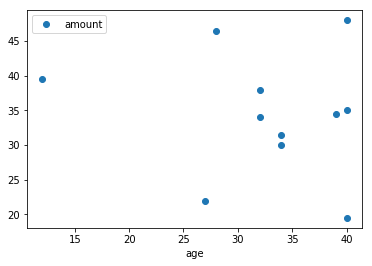

In [14]:
#Plot amount of trips relative to age of bee
summed_age.plot(x='age',y='amount',style='o')

In [32]:
#Creating empty dataframe for the amount of triplengths occuring for each age of the bees
triplength_age_df=pd.DataFrame(index=sorted(list(set(bee_days_since_birth))), columns=sorted(list(set(flat_list))))
triplength_age_df[:]=0
triplength_age_df

,1,2,3,4,5,6,7,8,9,10,...,69,72,76,86,108,112,129,137,185,200
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Creating a Counter which holds the amount of triplengths for each bee
counts = Counter()
for bee in range (len(bee_days_since_birth)):
    counts[bee]=Counter(rolled_trip_lengths[bee])
counts

Counter({0: Counter({3: 5,
                  4: 7,
                  5: 1,
                  7: 4,
                  8: 2,
                  9: 2,
                  11: 3,
                  13: 1,
                  14: 1,
                  18: 1,
                  23: 2,
                  25: 1,
                  27: 1,
                  29: 1,
                  32: 1,
                  43: 1,
                  46: 1,
                  67: 1,
                  69: 1,
                  112: 1}),
         1: Counter({1: 1,
                  2: 3,
                  3: 8,
                  5: 2,
                  6: 4,
                  7: 2,
                  8: 1,
                  10: 1,
                  11: 2,
                  12: 1,
                  15: 1,
                  16: 1,
                  20: 1,
                  23: 1,
                  32: 1,
                  43: 1}),
         2: Counter({2: 1,
                  3: 4,
                  4: 1,
                  5: 1,
   

In [34]:
for counter_index in range (len(bee_days_since_birth)):
    for counter_triplength,counter_amount in counts[counter_index].items():
        triplength_age_df.loc[bee_days_since_birth[counter_index], counter_triplength] += counter_amount
triplength_age_df

,1,2,3,4,5,6,7,8,9,10,...,69,72,76,86,108,112,129,137,185,200
12,0,3,4,2,3,3,2,3,1,2,...,0,0,0,1,0,0,0,0,0,0
27,0,1,4,1,1,0,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
28,2,4,8,3,4,4,1,2,2,1,...,0,0,1,0,1,0,1,1,0,0
32,2,2,11,12,4,3,5,3,3,0,...,1,0,0,0,0,1,0,0,0,0
34,2,4,11,4,4,11,4,3,0,3,...,0,0,0,0,0,0,0,0,0,0
39,1,0,9,5,4,3,2,3,2,0,...,0,0,0,0,0,0,0,0,0,0
40,1,1,15,6,9,8,5,3,3,5,...,0,1,0,0,0,0,0,0,1,1


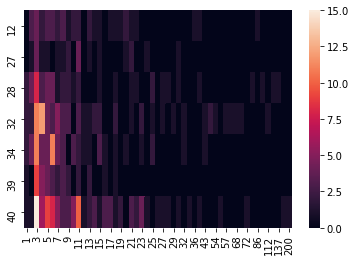

In [35]:
#TODO: create also a normalized version of the heatmap (divide values by amount of bees with that age)
sns.heatmap(triplength_age_df, annot=False, fmt=".1f")

## List of Variables

### Import Variables

connect_str : String data for accessing the database

meta        : contains meta data from bb_utils about bees that is used to get the data about forager bees

### Parameters

num_hours                    : Number of hours loaded from the database (int)

datetime_start               : Starting point in the database (Datetime(y,m,d,h))

bin_size_in_hours            : TBD

num_intervals_per_hour       : How many intervals for a single hour the dataframes will have (int)

rolling_window_size          : How big is the window for the rolling median function to filter noise (int)

total_num_intervals          : How many intervals are there in total - calculated with the product of num_hours and num_intervals_per_hour

group_id                     : ID of the forager group of bees that gets loaded 

bee_ids_as_beesbookid_format : Bee IDs from the chosen forager group in beesbookid format

bee_ids_from_group           : Bee IDs from the chosen forager group in ferwa format (which is also used in the database)

bee_days_since_birth         : Age of every chosen bee (Array of Int)

csv_name_and_location        : Filepath to csv file with the presence dataframe, containing the bee ids and their detections within given intervalls for a given timeframe (Str)

date_string                  : Filename for saving trips_df into a csv file


### Dataframes

presence_df             : contains the Bee IDs and and their detections (0 or 1) within given intervalls for a given amount of hours, starting from datetime_start

presence_df_with_offset : presence_df with rolling_window_offset times copied first and last column, so the rolling median operation doesn't calculate NaN values. Used copies of the first and last column as neutral elements, since all 0s or 1s could have caused false information about trip starts or endings

rolled                  : presence_df table after the filtering of noise with a rolling median window

diffed                  : dataframe that only contains 1 and -1 for each bee when a trip starts or ends - calculated by the diff function applied to the rolled dataframe

diffed_with_id          : diffed dataframe with an additional column containing the bee ids

diffed_with_age         : diffed dataframe with an additional column containing the bee ages

trips_df                : dataframe containing the amount of trips for each bee for each hour

triplength_age_df       : dataframe containing the amount of each occuring triplength in relation to the age of the bees

### to be named

trip_lengths            : List of trip lengths for each bee (List of Lists of Int)

curr_bee_trip_lenghts   : List of trip lengths for current bee (List of Int)

curr_trip_length        : amount of trips for the current bee within the loop; used to prevent appending empty lists to trip_lengths (Int)

bool_is_present         : 0 or 1 depending wether the bee has a detection within an interval or not (boolean)

flat_list               : Conversion of trip_lengths into a normal list containing all the triplengths (List of Int)

flat_series             : Conversion of flat_list into pd.Series (Series of Int)

rolling_window_offset   : Size of the offset required for the rolling window to each side of the center - calculated by the floor of the windowsize devided by 2 (Int)

first_col               : first column of presence_df, is used to duplicate it for the rolling_window_offset (Series of Int)

last_col                : last column of presence_df, is used to duplicate it for the rolling_window_offset (Series of Int)

counts                  : Array of Counters which contain the triplength and the amount. Each Position in the array represents one element of bee_days_since_birth (meaning one                                 certain age)